# *Importing Dependencies*

In [145]:
import pandas as pd
import numpy as np
import librosa
import resampy
from pydub import AudioSegment
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


*Here is the filename identifiers as per the official RAVDESS website: Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:* 

*Video-only (02) Speech (01) Fearful (06) Normal intensity (01) Statement "dogs" (02) 1st Repetition (01) 12th Actor (12) - Female (as the actor ID number is even)*

In [116]:
Ravdess = "audio_speech_actors_01-24"

In [117]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/' + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Ravdess_df.to_csv("data_path.csv",index=False)

In [176]:
data_path = Ravdess_df

# *Data Augmentation*

In [156]:
def augment_data(data, sample_rate):
    augmented_data = [data]
    
    # Data with noise
    noise_data = noise(data)
    augmented_data.append(noise_data)
    
    # Data with stretching
    stretched_data = stretch(data)
    augmented_data.append(stretched_data)
    
    # Data with shifting
    shifted_data = shift(data)
    augmented_data.append(shifted_data)
    
    # Data with pitching
    pitched_data = pitch(data, sample_rate)
    augmented_data.append(pitched_data)
    
    return augmented_data

def extract_features(data, sample_rate):
    # Convert data to floating-point
    data = data.astype(float)
    
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally
    
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally
    
    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally
    
    return result

X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Augment the data
    augmented_data = augment_data(data, sample_rate)
    
    for augmented_sample in augmented_data:
        features = extract_features(augmented_sample, sample_rate)
        X.append(features)
        Y.append(emotion)

In [159]:
len(X), len(Y), data_path.Path.shape

(7200, 7200, (1440,))

In [161]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.tail()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
7195,0.219971,0.676553,0.613857,0.591720,0.571173,0.551790,0.565728,0.585875,0.636384,0.642514,...,5.655022e-03,4.140741e-03,3.525571e-03,2.786390e-03,2.527809e-03,2.580479e-03,2.437243e-03,1.115113e-03,9.113736e-05,surprise
7196,0.283520,0.689902,0.676948,0.677849,0.665456,0.656665,0.645970,0.627963,0.654968,0.674875,...,5.935726e-03,4.393193e-03,3.785478e-03,3.010152e-03,2.791601e-03,2.792838e-03,2.638580e-03,1.336170e-03,3.254509e-04,surprise
7197,0.242413,0.796311,0.768334,0.764206,0.816133,0.930378,0.816081,0.626156,0.641565,0.689419,...,1.710869e+19,2.112383e+19,2.127284e+19,2.740071e+19,3.625517e+19,3.674989e+19,5.474821e+19,1.017659e+20,8.525715e+19,surprise
7198,0.219184,0.671851,0.600689,0.584577,0.565839,0.547575,0.565192,0.587128,0.633421,0.638299,...,5.655015e-03,4.140713e-03,3.525625e-03,2.786359e-03,2.527803e-03,2.580490e-03,2.437239e-03,1.115109e-03,9.114064e-05,surprise
7199,0.220510,0.750819,0.775873,0.779223,0.807882,0.805722,0.724768,0.734038,0.708168,0.715094,...,2.237934e+19,2.542273e+19,2.035155e+19,2.223413e+19,2.199621e+19,2.020378e+19,2.106492e+19,1.969716e+19,1.917396e+19,surprise


# *Data Preparation*

In [200]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [163]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [164]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 162), (5400, 8), (1800, 162), (1800, 8))

In [135]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_data['Emotions'])
y_test_encoded = label_encoder.transform(test_data['Emotions'])

In [165]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 162), (5400, 8), (1800, 162), (1800, 8))

In [166]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 162, 1), (5400, 8), (1800, 162, 1), (1800, 8))

# *Model Defining and Compiling*

In [167]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 81, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 41, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_15 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 21, 128)          

In [168]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
85/85 [==============================] - 28s 251ms/step - loss: 2.0535 - accuracy: 0.1583 - val_loss: 2.0216 - val_accuracy: 0.1950 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 18s 208ms/step - loss: 2.0167 - accuracy: 0.1891 - val_loss: 1.9608 - val_accuracy: 0.2061 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 17s 202ms/step - loss: 1.9498 - accuracy: 0.2354 - val_loss: 1.9106 - val_accuracy: 0.2744 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 19s 223ms/step - loss: 1.8984 - accuracy: 0.2594 - val_loss: 1.8424 - val_accuracy: 0.2856 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 19s 228ms/step - loss: 1.8552 - accuracy: 0.2815 - val_loss: 1.7737 - val_accuracy: 0.3050 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 19s 229ms/step - loss: 1.8126 - accuracy: 0.2909 - val_loss: 1.7335 - val_accuracy: 0.3283 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 19s 228ms/st

# *Evaluation*

57/57 [==============================] - 3s 54ms/step - loss: 1.4772 - accuracy: 0.6383
Accuracy of our model on test data :  63.83333206176758 %


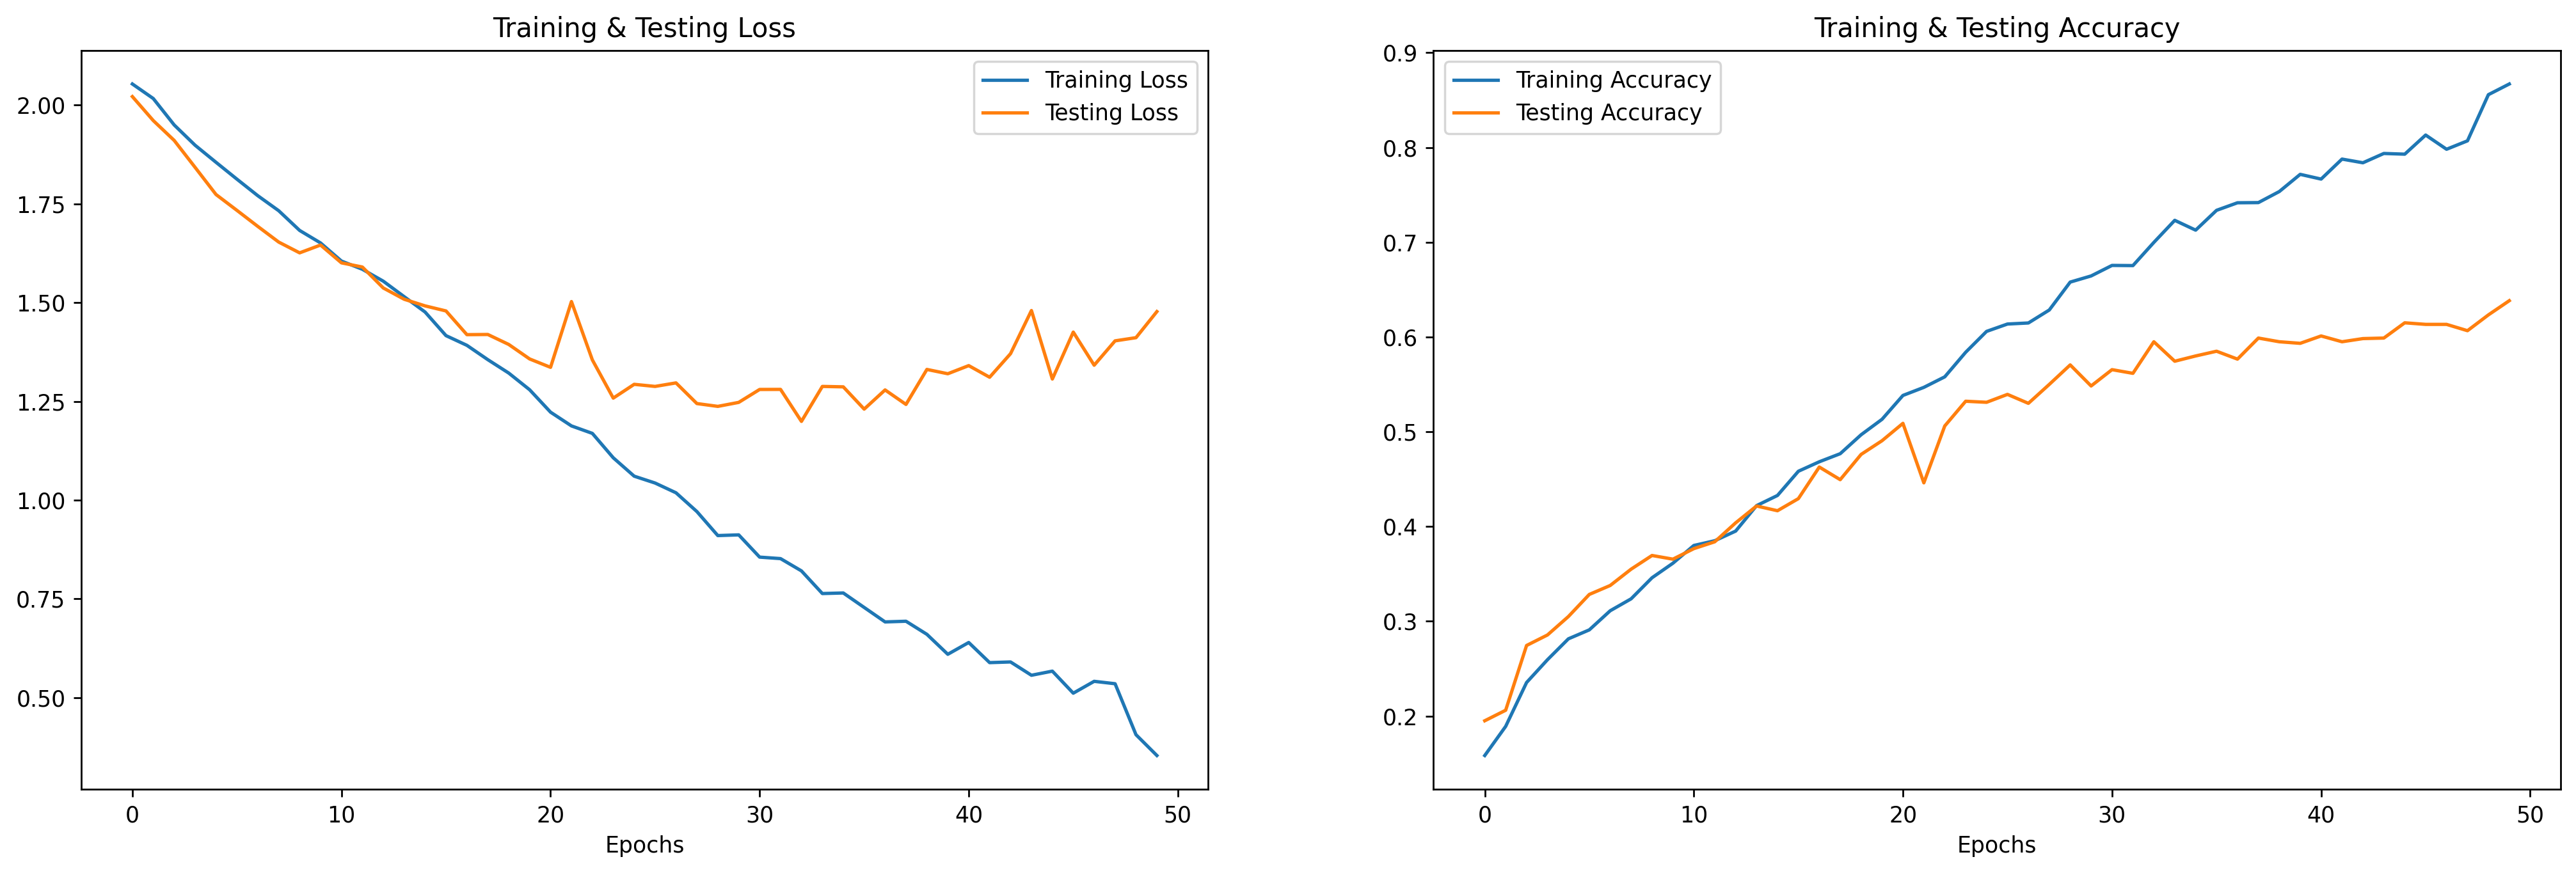

In [170]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2, dpi = 250)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [171]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

57/57 [==============================] - 4s 56ms/step


In [194]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
print('Correctly Predicted Labels: ',len(df[df['Predicted Labels'] == df['Actual Labels']]), '\nTotal Labels: ',len(df['Predicted Labels']))
df

Correctly Predicted Labels:  1149 
Total Labels:  1800


,Predicted Labels,Actual Labels
0,disgust,disgust
1,angry,neutral
2,calm,calm
3,happy,happy
4,angry,surprise
...,...,...
1795,calm,calm
1796,sad,sad
1797,disgust,disgust
1798,disgust,disgust


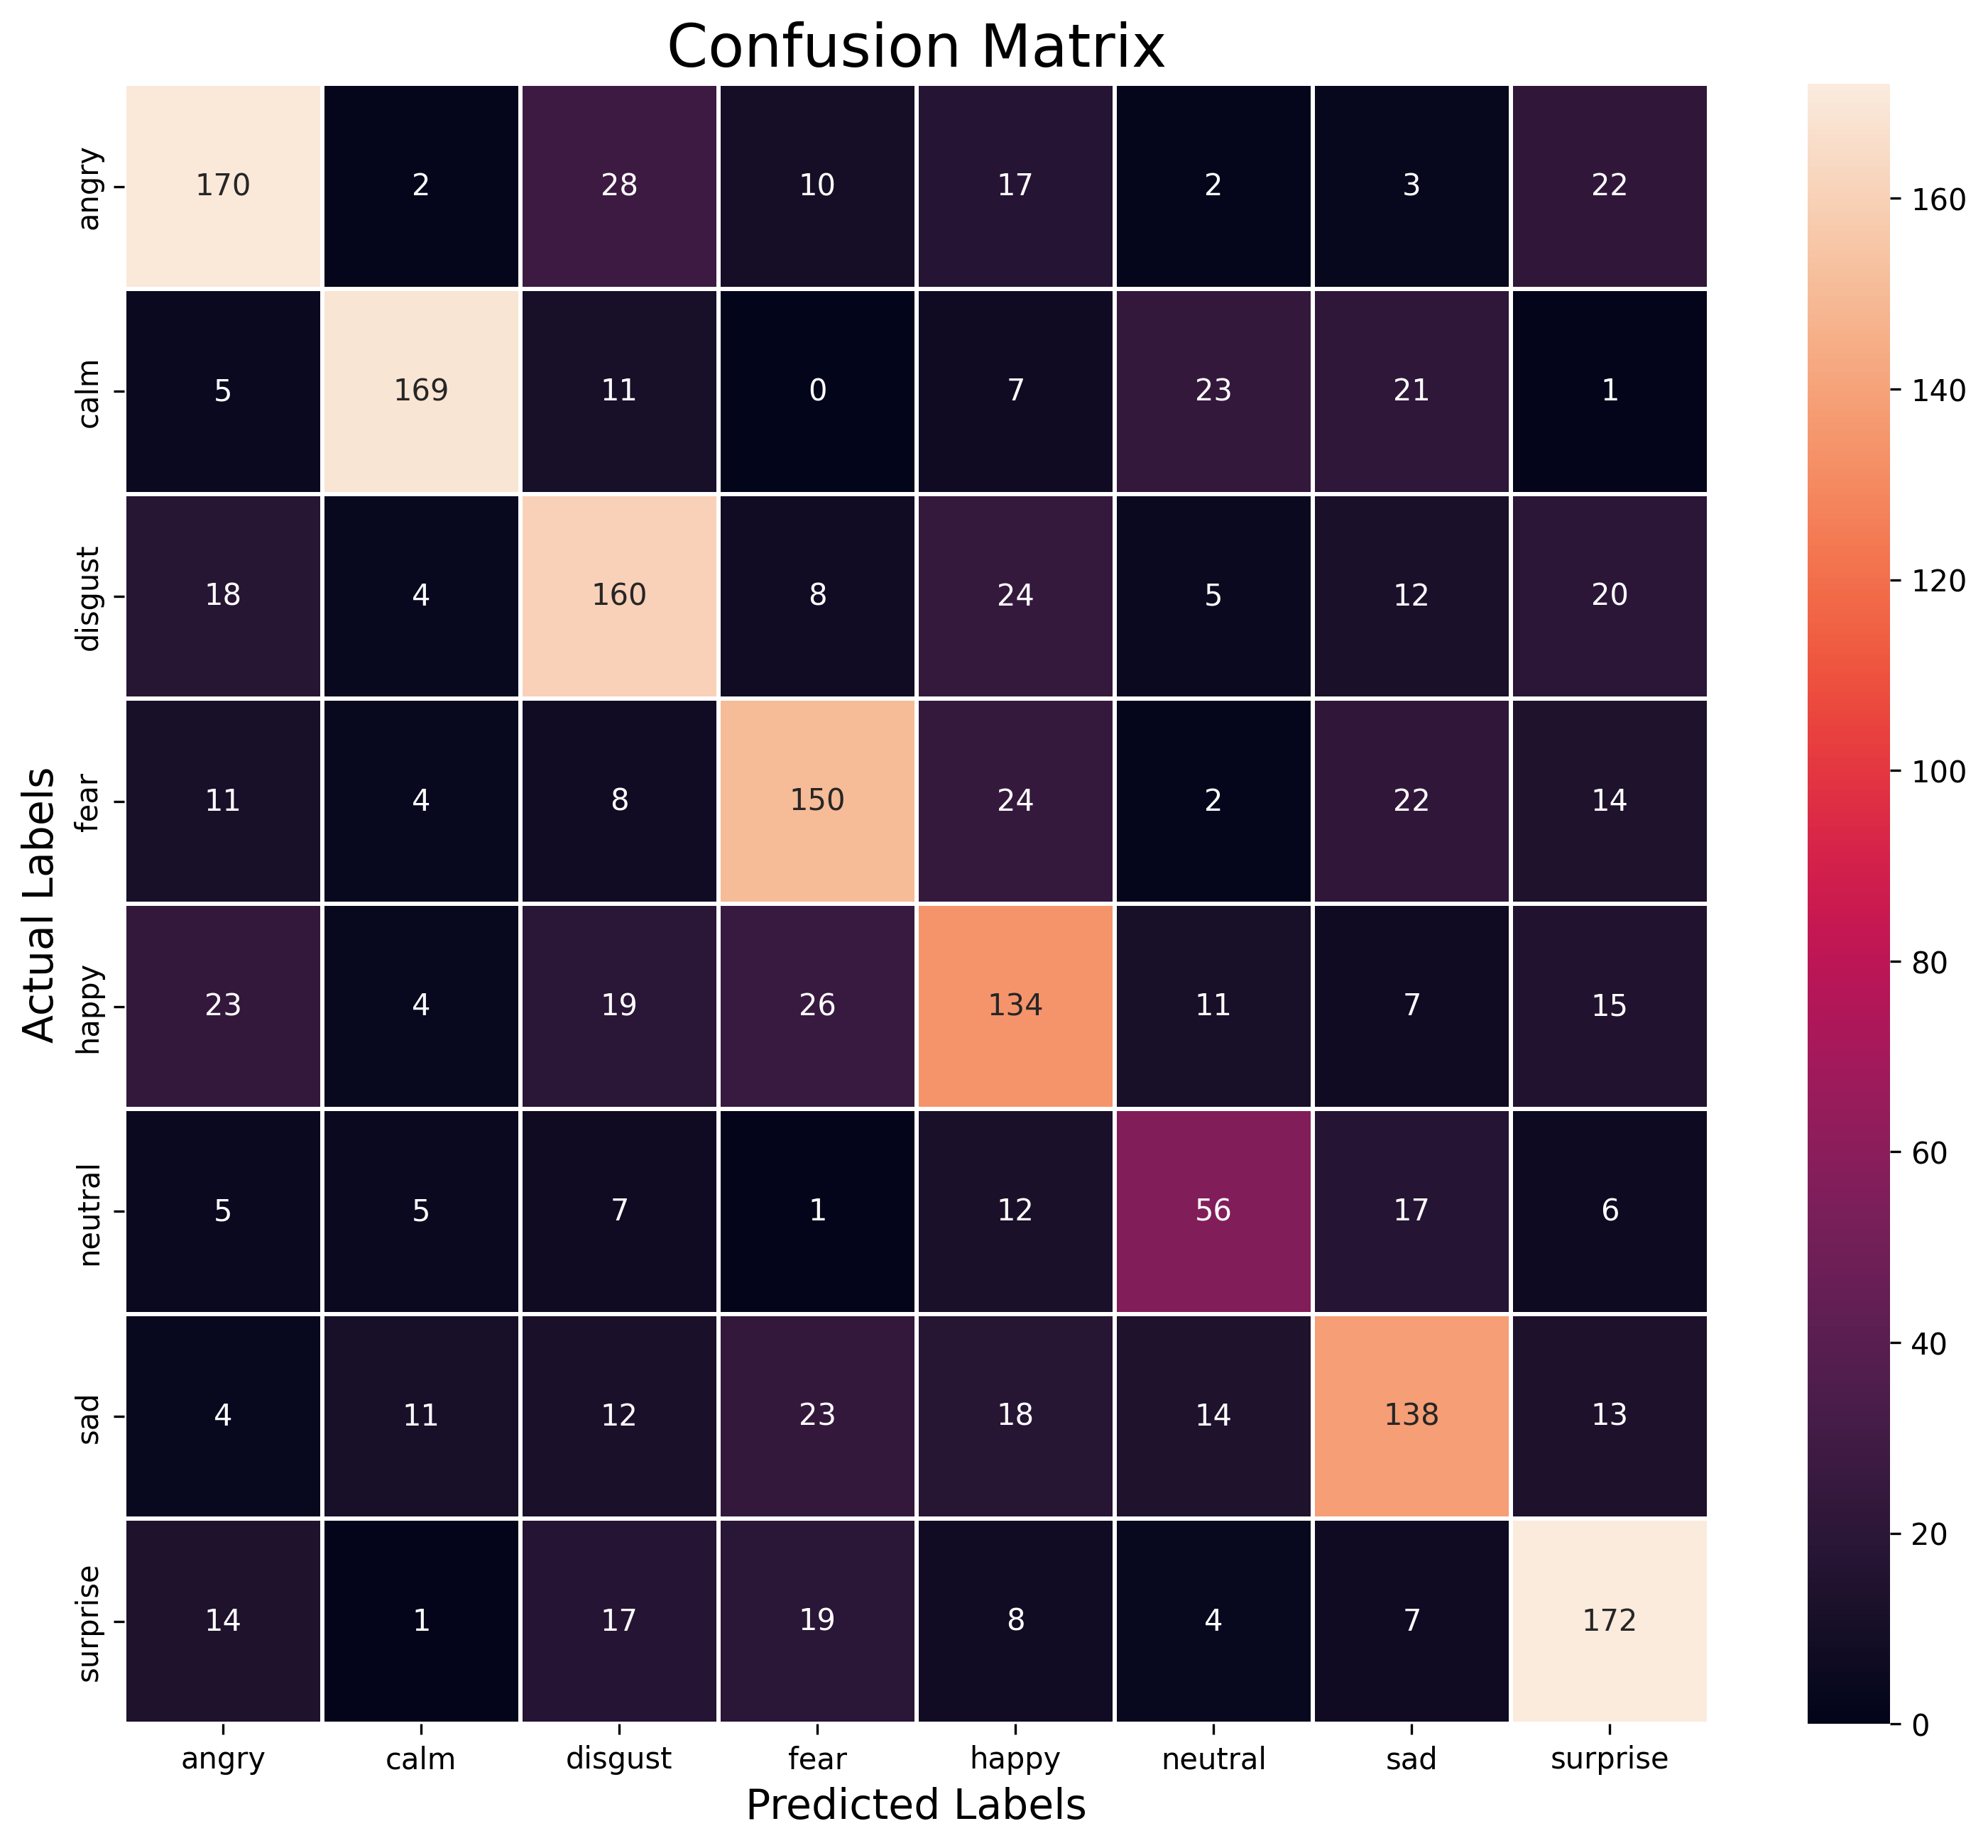

In [193]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10), dpi =300)
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [201]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.68      0.67      0.67       254
        calm       0.84      0.71      0.77       237
     disgust       0.61      0.64      0.62       251
        fear       0.63      0.64      0.64       235
       happy       0.55      0.56      0.55       239
     neutral       0.48      0.51      0.50       109
         sad       0.61      0.59      0.60       233
    surprise       0.65      0.71      0.68       242

    accuracy                           0.64      1800
   macro avg       0.63      0.63      0.63      1800
weighted avg       0.64      0.64      0.64      1800



# *Real Time Prediction*

In [177]:
model.save('voice_model.h5')

C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [202]:
import numpy as np
import librosa
import io
import pyaudio
import soundfile as sf
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('voice_model.h5')

# Function to extract features from real-time audio
def extract_realtime_features(data, sample_rate):
    features = extract_features(data, sample_rate)
    return np.expand_dims(features, axis=0)

# Function for real-time emotion detection
def real_time_emotion_detection():
    chunk_size = 1024  # Adjust the chunk size according to your needs
    format = pyaudio.paInt16
    channels = 1
    sample_rate = 44100  # Make sure it matches the sample rate used during training

    p = pyaudio.PyAudio()

    stream = p.open(format=format,
                    channels=channels,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=chunk_size)

    print("Real-time emotion detection started. Press Ctrl+C to stop.")

    try:
        while True:
            data = np.frombuffer(stream.read(chunk_size), dtype=np.int16)

            # Save the real-time audio to a temporary file (optional)
            sf.write('realtime_audio.wav', data, sample_rate)

            # Process the real-time audio
            features = extract_realtime_features(data, sample_rate)
            features = np.expand_dims(features, axis=2)

            # Make prediction
            prediction = model.predict(features)
            emotion_label = label_encoder.inverse_transform([np.argmax(prediction)])

            print("Predicted Emotion:", emotion_label[0])

    except KeyboardInterrupt:
        print("Real-time emotion detection stopped.")
    finally:
        stream.stop_stream()
        stream.close()
        p.terminate()

if __name__ == "__main__":
    real_time_emotion_detection()


Real-time emotion detection started. Press Ctrl+C to stop.


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 6s 6s/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 132ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 96ms/step
Predicted Emotion: sad


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 185ms/step
Predicted Emotion: disgust


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 242ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 122ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 108ms/step
Predicted Emotion: sad


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 314ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 103ms/step
Predicted Emotion: sad


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 105ms/step
Predicted Emotion: disgust


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 99ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 79ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 142ms/step
Predicted Emotion: disgust


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 201ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 176ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 110ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 75ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 85ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 165ms/step
Predicted Emotion: disgust


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 90ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 139ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 181ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 91ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 93ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 173ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 95ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 125ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 151ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 335ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 81ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 127ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 89ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 83ms/step
Predicted Emotion: calm


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1/1 [==============================] - 0s 182ms/step
Predicted Emotion: disgust


C:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


Real-time emotion detection stopped.
